In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
data = np.loadtxt("./output/resultados_3.dat").T

In [46]:
data[0]

array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -7.4759060e+04, -3.9506430e+04,
        3.4458000e+02,  3.1076060e+04,  3.9840090e+04,  0.0000000e+00,
        6.7218610e+04,  7.9441390e+04, -2.7252200e+04,  7.8456600e+04,
        0.0000000e+00, -7.8456600e+04,  1.2728971e+05,  2.2201750e+04,
       -1.1032455e+05, -4.7722000e+04,  1.0990672e+05, -2.8886230e+04,
        1.0976936e+05, -1.1018719e+05,  6.0550690e+04,  1.7058810e+04,
       -3.8675890e+04,  8.8648680e+04, -9.4207330e+04, -1.8506228e+05,
       -2.0828840e+04,  4.1702100e+04, -2.4375810e+04, -1.2476800e+04,
        2.9976410e+04,  3.4613330e+04,  4.9297100e+03, -1.9964490e+04,
        4.4327400e+04,  2.3007710e+04,  4.0787670e+04, -1.4758822e+05,
       -1.0648733e+05,  7.7023310e+04,  1.9059740e+04,  1.3618350e+04,
        6.6868350e+04,  1.5075140e+04, -8.2771320e+04,  6.1237980e+04,
        3.8960140e+04,  3.5832160e+04,  7.1182070e+04,  2.3461330e+04,
      

(array([27., 23., 23.,  9., 12., 15., 20., 21., 17., 14., 14., 21.,  7.,
        11., 10., 13.,  1., 11.,  7., 11.,  8.,  4.,  4.,  2.,  6.,  7.,
         2.,  4.,  7.,  2.,  3.,  4.,  6.,  5.,  3.,  0.,  8.,  6.,  3.,
         5.,  4.,  4.,  3.,  0.,  2.,  1.,  1.,  2.,  1.,  1.,  3.,  2.,
         0.,  1.,  4.,  4.,  2.,  4.,  1.,  1.,  3.,  3.,  2.,  2.,  4.,
         2.,  2.,  2.,  2.,  3.,  1.,  2.,  1.,  1.,  3.,  2.,  3.,  0.,
         0.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,  2.]),
 array([     0.    ,   1968.1633,   3936.3266,   5904.4899,   7872.6532,
          9840.8165,  11808.9798,  13777.1431,  15745.3064,  17713.4697,
         19681.633 ,  21649.7963,  23617.9596,  25586.1229,  27554.2862,
         29522.4495,  31490.6128,  33458.7761,  35426.9394,  37395.1027,
         39363.266 ,  41331.4293,  43299.5926,  45267.7559,  47235.9192,
         49204.0825,  51172.2458,  53140.4091,  55108.5724,  57076.73

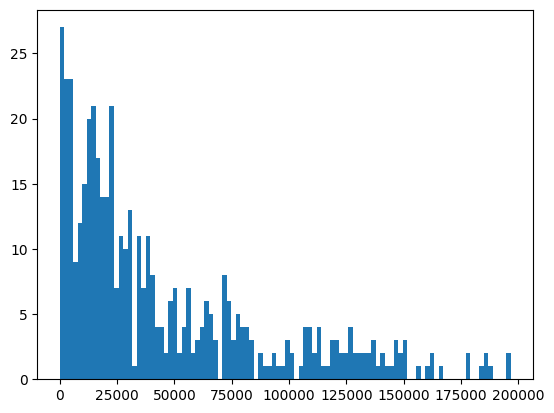

In [45]:
plt.hist(np.abs(data[1]),bins = 100)